In [1]:
#Import libraries
from sqlalchemy import create_engine
import pandas as pd
from sqlalchemy import inspect
from datetime import datetime as dt
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport


# EDA steps:
## 1- Sourcing Data

In [2]:
engine = create_engine("sqlite:///sqlite/MTA_1.db")
all_tables = inspect(engine)
print(all_tables.get_table_names())

mta = pd.read_sql('SELECT * FROM mta;', engine)
mta.head()

['mta']


,C/A,UNIT,SCP,STATION,LINENAME,DIVISON,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,00:00:00,REGULAR,7578734,2590325
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,04:00:00,REGULAR,7578740,2590327
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,08:00:00,REGULAR,7578749,2590340
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,12:00:00,REGULAR,7578789,2590386
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,16:00:00,REGULAR,7578897,2590418


# 2- Cleaning Data

In [3]:
#Check For Missing Data
mta.isnull().sum()


In [83]:
mta.isnull().sum()

C/A             0
UNIT            0
SCP             0
STATION         0
LINENAME        0
DIVISON         0
DATE            0
TIME            0
DESC            0
ENTRIES         0
EXITS           0
datetime        0
n_ent           0
n_ext           0
turn_traffic    0
day_of_week     0
dtype: int64

In [ ]:
# combining Date & time columns 

mta['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)
mta.sort_values(by=['datetime'], inplace=True)

In [4]:
#convert ENTRIES and EXITS to number of entries and number of exits 

mta['n_ent'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta['n_ext'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

In [5]:
# get total turnstile traffic out of entries and exits

mta['turn_traffic'] = mta.n_ent + mta.n_ext
mta.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISON,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_ent,n_ext,turn_traffic
2633939,PTH04,R551,00-01-04,GROVE STREET,1,PTH,08/27/2021,23:57:09,REGULAR,14168,92933,2021-08-27 23:57:09,28.0,355.0,383.0
2637446,PTH12,R542,00-04-02,TWENTY THIRD ST,1,PTH,08/27/2021,23:57:50,REGULAR,31262,891186,2021-08-27 23:57:50,1.0,74.0,75.0
2639243,PTH17,R541,01-00-02,THIRTY THIRD ST,1,PTH,08/27/2021,23:59:08,REGULAR,1,98219,2021-08-27 23:59:08,0.0,92.0,92.0
2636132,PTH07,R550,00-01-08,CITY / BUS,1,PTH,08/27/2021,23:59:43,REGULAR,40889,124878,2021-08-27 23:59:43,9.0,54.0,63.0
2634218,PTH04,R551,00-04-05,GROVE STREET,1,PTH,08/27/2021,23:59:56,REGULAR,312741,159053,2021-08-27 23:59:56,8.0,29.0,37.0


In [6]:

mask = (mta.n_ent >= 0) & (mta.n_ext >= 0) & (mta.turn_traffic >= 0) & (mta.turn_traffic < 3000)
mta = mta[mask]


In [7]:
#Add week days column to the dataframe

mta['day_of_week'] = mta['datetime'].apply(lambda x : x.weekday())
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISON,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_ent,n_ext,turn_traffic,day_of_week
73983,N192,R336,00-05-00,BEACH 60 ST,A,IND,05/29/2021,04:00:00,REGULAR,117440944,0,2021-05-29 04:00:00,0.0,0.0,0.0,5
34240,H010,R235,01-00-01,BEDFORD AV,L,BMT,05/29/2021,04:00:00,REGULAR,1199558,2770525,2021-05-29 04:00:00,16.0,35.0,51.0,5
74067,N193,R337,00-00-00,BEACH 44 ST,A,IND,05/29/2021,04:00:00,REGULAR,53119,137434,2021-05-29 04:00:00,1.0,14.0,15.0,5
74109,N193,R337,00-00-01,BEACH 44 ST,A,IND,05/29/2021,04:00:00,REGULAR,1193328,1494139,2021-05-29 04:00:00,2.0,11.0,13.0,5
73941,N192,R336,00-00-02,BEACH 60 ST,A,IND,05/29/2021,04:00:00,REGULAR,45077,26127,2021-05-29 04:00:00,9.0,7.0,16.0,5


In [8]:
#group stations by turnstile traffics 

stations_totals = mta.groupby('STATION', as_index=False).turn_traffic.sum()
stations_totals.sort_values(by='turn_traffic', ascending=False, inplace=True)
stations_totals.head(10)

,STATION,turn_traffic
61,34 ST-PENN STA,9230504.0
59,34 ST-HERALD SQ,6931015.0
233,GRD CNTRL-42 ST,6827385.0
110,86 ST,6168750.0
14,14 ST-UNION SQ,5948788.0
46,23 ST,5529847.0
68,42 ST-PORT AUTH,5457160.0
9,125 ST,5364979.0
353,TIMES SQ-42 ST,5227830.0
226,FULTON ST,4819739.0


## 3- Visualizations

### 3.1 Top 10 Busiest stations

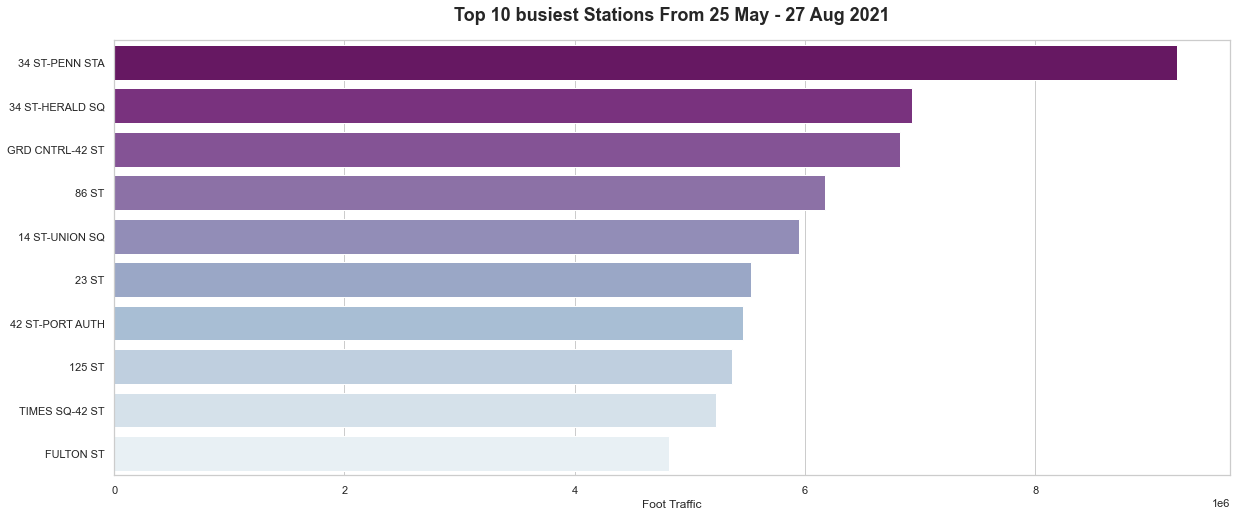

<Figure size 432x288 with 0 Axes>

In [98]:
# plot top 10 stations in terms of traffic 
from importlib import reload
reload(plt)

plt.figure(figsize=[20,8])
sns.set(style="whitegrid")
sns.barplot(x='turn_traffic', y='STATION', data=stations_totals.head(10),palette="BuPu_r", orient="h");

plt.title('Top 10 busiest Stations From 25 May - 27 Aug 2021',weight = 'bold', pad='20', size=18)
plt.xlabel('Foot Traffic')
plt.ylabel('')
plt.show()

plt.savefig('Top 10 Busiest sts.png')

### 3.2 plotting for each month alone to compare between them


In [99]:

#filter on June data
mta_june =mta[(mta.DATE <= '06/30/2021')]


In [ ]:
# apllying the same steps done above for each month
mta_june['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)
mta_june.sort_values(by=['datetime'], inplace=True)

mta_june['n_ent'] = mta_june.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta_june['n_ext'] = mta_june.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

mta_june['turn_traffic'] = mta_june.n_ent + mta_june.n_ext

mask_june = (mta_june.n_ent >= 0) & (mta_june.n_ext >= 0) & (mta_june.turn_traffic >= 0) & (mta_june.turn_traffic < 3000)
mta_june = mta_june[mask_june]


mta_june['total_traffic'] = mta_june.groupby('STATION').turn_traffic.transform('sum')
mta_june.head()

stations_totals_june = mta_june[['STATION', 'total_traffic']]

stations_totals_june = stations_totals_june.drop_duplicates()

stations_totals_june.sort_values(by='total_traffic', ascending=False, inplace=True)

top_ten_stations_totals_june = pd.DataFrame(stations_totals_june.head(10))
top_ten_stations_totals_june




In [ ]:
#filter on July data

mta_july =mta[(mta.DATE >= '07/01/2021') & (mta.DATE >= '07/30/2021')]

mta_july['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)
mta_july.sort_values(by=['datetime'], inplace=True)

mta_july['n_ent'] = mta_july.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta_july['n_ext'] = mta_july.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

mta_july['turn_traffic'] = mta_july.n_ent + mta_july.n_ext

mask_july = (mta_july.n_ent >= 0) & (mta_june.n_ext >= 0) & (mta_june.turn_traffic >= 0) & (mta_june.turn_traffic < 3000)
mta_july = mta_july[mask_july]


mta_june['total_traffic'] = mta_june.groupby('STATION').turn_traffic.transform('sum')
mta_june.head()

stations_totals_july = mta_june[['STATION', 'total_traffic']]

stations_totals_july = stations_totals_july.drop_duplicates()

stations_totals_july.sort_values(by='total_traffic', ascending=False, inplace=True)

top_ten_stations_totals_july = pd.DataFrame(stations_totals_july.head(10))
top_ten_stations_totals_july


In [ ]:
#filter on August data

mta_Aug =mta[(mta.DATE >= '08/01/2021')]

mta_Aug['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)
mta_Aug.sort_values(by=['datetime'], inplace=True)

mta_Aug['n_ent'] = mta_Aug.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta_Aug['n_ext'] = mta_Aug.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

mta_Aug['turn_traffic'] = mta_Aug.n_ent + mta_Aug.n_ext

mask_Aug = (mta_Aug.n_ent >= 0) & (mta_Aug.n_ext >= 0) & (mta_Aug.turn_traffic >= 0) & (mta_Aug.turn_traffic < 3000)
mta_Aug = mta_Aug[mask_Aug]


mta_Aug['total_traffic'] = mta_Aug.groupby('STATION').turn_traffic.transform('sum')
mta_Aug.head()

stations_totals_Aug = mta_Aug[['STATION', 'total_traffic']]

stations_totals_Aug = stations_totals_Aug.drop_duplicates()

stations_totals_Aug.sort_values(by='total_traffic', ascending=False, inplace=True)

top_ten_stations_totals_Aug = pd.DataFrame(stations_totals_Aug.head(10))
top_ten_stations_totals_Aug

In [103]:
top_ten_stations_totals_june['Month'] = 'June'
top_ten_stations_totals_july['Month'] = 'July'
top_ten_stations_totals_Aug['Month'] = 'August'

top_ten_stations_totals_june = top_ten_stations_totals_june.reset_index()
top_ten_stations_totals_july = top_ten_stations_totals_july.reset_index()
top_ten_stations_totals_Aug = top_ten_stations_totals_Aug.reset_index()

In [104]:
#concat all months together
top_ten_stations_together = pd.concat([top_ten_stations_totals_june, top_ten_stations_totals_july,top_ten_stations_totals_Aug], ignore_index = True)
top_ten_stations_together

,index,STATION,total_traffic,Month
0,57799,34 ST-PENN STA,3197128.0,June
1,3823,34 ST-HERALD SQ,2478974.0,June
2,162099,GRD CNTRL-42 ST,2341763.0,June
3,168022,86 ST,2222751.0,June
4,5826,14 ST-UNION SQ,2148481.0,June
5,57883,23 ST,1977547.0,June
6,148042,125 ST,1942951.0,June
7,54695,42 ST-PORT AUTH,1876721.0,June
8,3235,TIMES SQ-42 ST,1777759.0,June
9,97753,FULTON ST,1671160.0,June


<Figure size 1440x576 with 0 Axes>

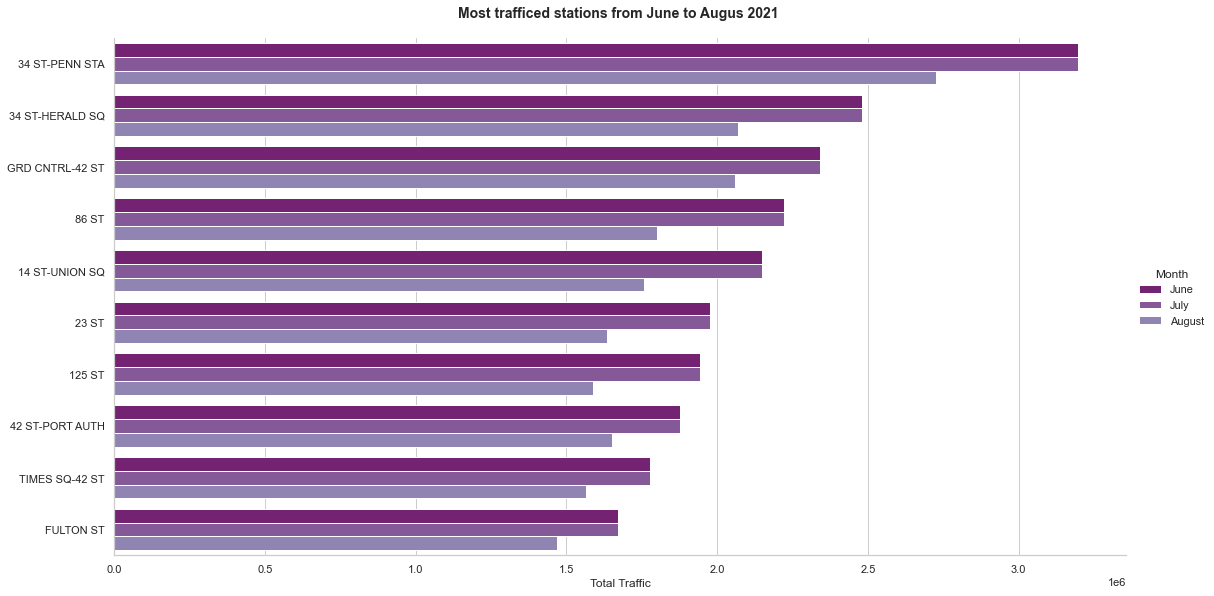

In [105]:
from importlib import reload
reload(plt)

plt.figure(figsize=[20,8])
sns.set(style="whitegrid")

all_months_together = sns.catplot(data = top_ten_stations_together, kind = "bar",
    y = "STATION", x ="total_traffic", hue = "Month", palette = sns.color_palette("BuPu_r"), height=8,aspect = 2)

plt.xlabel('Total Traffic')
plt.ylabel('')
plt.title('Most trafficed stations from June to Augus 2021 ', weight = 'bold', pad='20', size=14)


plt.savefig('Most trafficed stations from June to Augus 2021.png')

### 3.3 plotting the Average of Traffic in terms of week days

In [106]:
s = [each for _, each in stations_totals.head(10)['STATION'].items()]
top_ranked_df = pd.DataFrame(mta[mta.STATION.isin(s)])

In [107]:
df1 = mta[mta.STATION.isin(s)].groupby(['STATION', 'DATE', 'day_of_week'], as_index=False).turn_traffic.sum()
df1['Avg_of_traffic'] = df1.groupby(['STATION','day_of_week']).turn_traffic.transform('mean')
df1.drop_duplicates(inplace=True)
df1.head()

,STATION,DATE,day_of_week,turn_traffic,Avg_of_traffic
0,125 ST,05/29/2021,5,35338.0,49662.692308
1,125 ST,05/30/2021,6,33724.0,40236.923077
2,125 ST,05/31/2021,0,41700.0,58932.615385
3,125 ST,06/01/2021,1,65118.0,64776.538462
4,125 ST,06/02/2021,2,66230.0,66246.384615


In [108]:
weekdays = {'0':'Monday','1':'Tuesday','2':'Wednesday','3':'Thursday','4':'Friday','5':'Saturday','6':'Sunday'}
df1.day_of_week = df1.day_of_week.map(lambda x : str(x)).map(weekdays)

df1.head()

,STATION,DATE,day_of_week,turn_traffic,Avg_of_traffic
0,125 ST,05/29/2021,Saturday,35338.0,49662.692308
1,125 ST,05/30/2021,Sunday,33724.0,40236.923077
2,125 ST,05/31/2021,Monday,41700.0,58932.615385
3,125 ST,06/01/2021,Tuesday,65118.0,64776.538462
4,125 ST,06/02/2021,Wednesday,66230.0,66246.384615


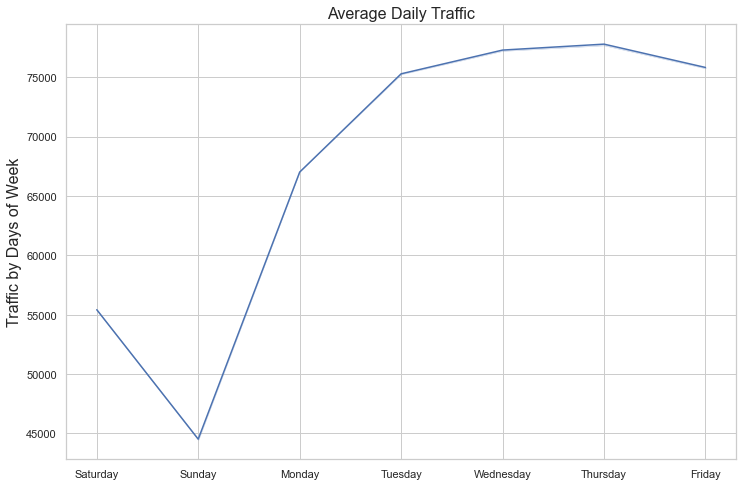

In [109]:
from importlib import reload
reload(plt)

plt.figure(figsize=[12,8])
sns.set_style('whitegrid')


sns.lineplot(x='day_of_week', y='Avg_of_traffic',  data=df1,ci=0, palette = sns.color_palette("BuPu_r") )
plt.xlabel('')
plt.ylabel('Traffic by Days of Week', fontsize=16)
plt.title('Average Daily Traffic', fontsize=16);


### 3.4 Heatmap for each station in(top 10  busiest stations) in terms of Time and Weekday

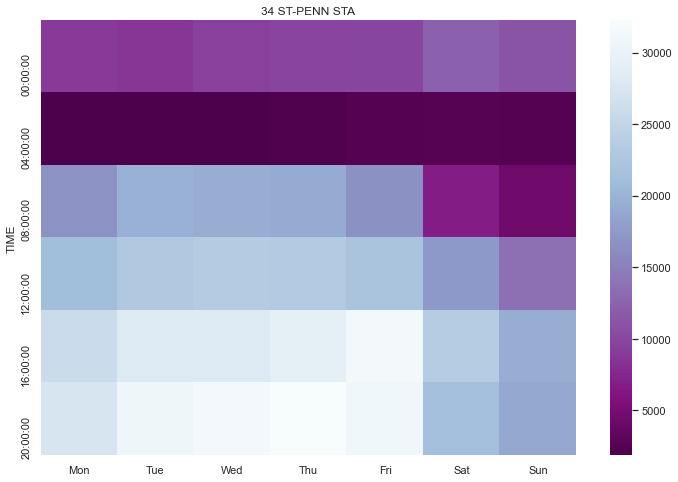

In [110]:
station_of_interest = '34 ST-PENN STA'

mta_penn = mta[mta['STATION'] == station_of_interest]
time_interval = '4H'

stations_day_time = mta_penn[['STATION', 'datetime','turn_traffic', 'day_of_week']]
stations_day_time_group = stations_day_time.groupby(['STATION','datetime'], as_index=False)
stations_day_time = stations_day_time_group[['turn_traffic']].sum()
rounded_day_time = stations_day_time.set_index('datetime').groupby(['STATION'])
rounded_day_time = rounded_day_time.resample(time_interval, convention='end').sum()

rounded_day_time = rounded_day_time.reset_index()
stations_day_time = rounded_day_time
stations_day_time['DAY'] = stations_day_time['datetime'].dt.dayofweek
stations_day_time['TIME'] = stations_day_time['datetime'].dt.time
stations_day_time
stations_day_time_group = stations_day_time.groupby(['STATION','DAY','TIME'])
stations_day_time_group = stations_day_time_group['turn_traffic'].mean().reset_index()

draw_station = stations_day_time_group

station_heatmap = draw_station.set_index(['DAY', 'TIME']).turn_traffic.unstack(0)
weekdays = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
station_heatmap.columns = [weekdays[c] for c in station_heatmap.columns]

fig, ax0 = plt.subplots(figsize=(12, 8))
ax0.set(title= '' + station_of_interest , xlabel='', ylabel='Time')
sns.heatmap(station_heatmap,ax=ax0, cmap='BuPu_r')
plt.show();


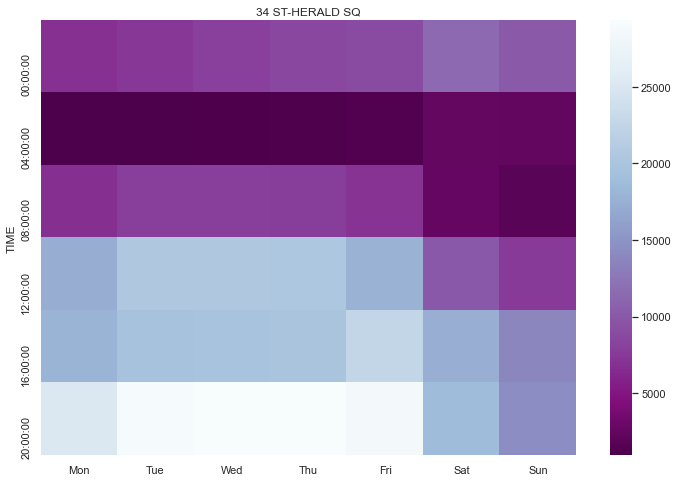

In [111]:
# the same for other stations 

station_of_interest = '34 ST-HERALD SQ'

mta_p = mta[mta['STATION'] == station_of_interest]
time_interval = '4H'

stations_day_time = mta_p[['STATION', 'datetime','turn_traffic', 'day_of_week']]
stations_day_time_group = stations_day_time.groupby(['STATION','datetime'], as_index=False)
stations_day_time = stations_day_time_group[['turn_traffic']].sum()
rounded_day_time = stations_day_time.set_index('datetime').groupby(['STATION'])
rounded_day_time = rounded_day_time.resample(time_interval, convention='end').sum()

rounded_day_time = rounded_day_time.reset_index()
stations_day_time = rounded_day_time
stations_day_time['DAY'] = stations_day_time['datetime'].dt.dayofweek
stations_day_time['TIME'] = stations_day_time['datetime'].dt.time
stations_day_time
stations_day_time_group = stations_day_time.groupby(['STATION','DAY','TIME'])
stations_day_time_group = stations_day_time_group['turn_traffic'].mean().reset_index()

draw_station = stations_day_time_group

station_heatmap = draw_station.set_index(['DAY', 'TIME']).turn_traffic.unstack(0)
weekdays = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
station_heatmap.columns = [weekdays[c] for c in station_heatmap.columns]

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.set(title= '' + station_of_interest , xlabel='', ylabel='Time')
sns.heatmap(station_heatmap,ax=ax1, cmap='BuPu_r')
plt.show();

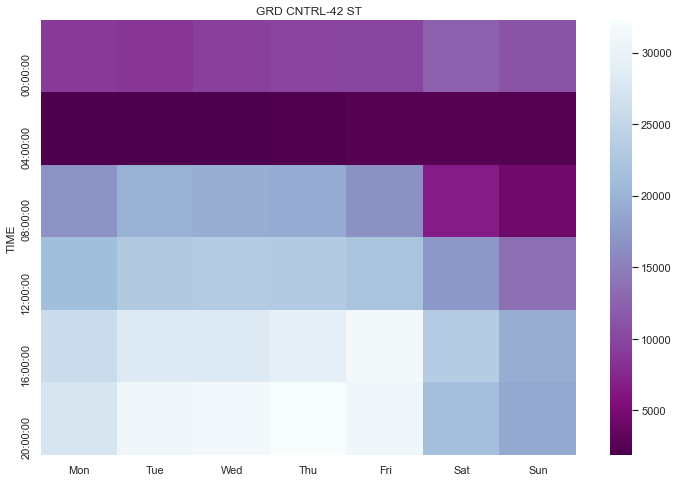

In [112]:
# GRD CNTRL-42 ST
station_of_interest = 'GRD CNTRL-42 ST'

mta_2 = mta[mta['STATION'] == station_of_interest]
time_interval = '4H'

stations_day_time = mta_penn[['STATION', 'datetime','turn_traffic', 'day_of_week']]
stations_day_time_group = stations_day_time.groupby(['STATION','datetime'], as_index=False)
stations_day_time = stations_day_time_group[['turn_traffic']].sum()
rounded_day_time = stations_day_time.set_index('datetime').groupby(['STATION'])
rounded_day_time = rounded_day_time.resample(time_interval, convention='end').sum()

rounded_day_time = rounded_day_time.reset_index()
stations_day_time = rounded_day_time
stations_day_time['DAY'] = stations_day_time['datetime'].dt.dayofweek
stations_day_time['TIME'] = stations_day_time['datetime'].dt.time
stations_day_time
stations_day_time_group = stations_day_time.groupby(['STATION','DAY','TIME'])
stations_day_time_group = stations_day_time_group['turn_traffic'].mean().reset_index()

draw_station = stations_day_time_group

station_heatmap = draw_station.set_index(['DAY', 'TIME']).turn_traffic.unstack(0)
weekdays = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
station_heatmap.columns = [weekdays[c] for c in station_heatmap.columns]

fig, ax2 = plt.subplots(figsize=(12, 8))
ax2.set(title= '' + station_of_interest , xlabel='', ylabel='Time')
sns.heatmap(station_heatmap,ax=ax2, cmap='BuPu_r')
plt.show();

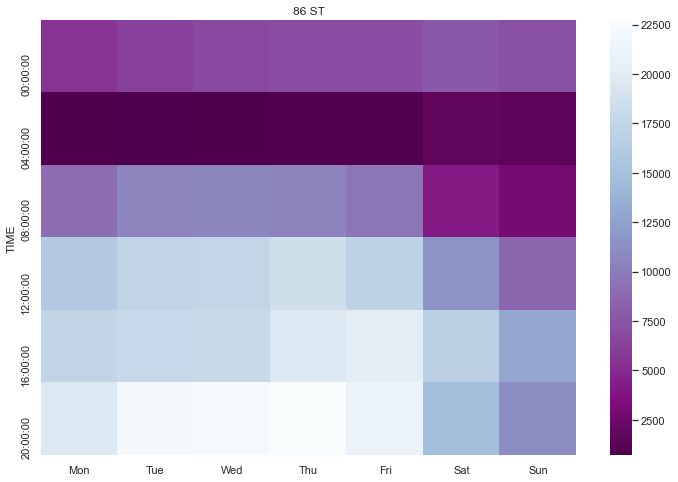

In [113]:
# 86 ST
station_of_interest = '86 ST'
mta_penn = mta[mta['STATION'] == station_of_interest]
time_interval = '4H'

stations_day_time = mta_penn[['STATION', 'datetime','turn_traffic', 'day_of_week']]
stations_day_time_group = stations_day_time.groupby(['STATION','datetime'], as_index=False)
stations_day_time = stations_day_time_group[['turn_traffic']].sum()
rounded_day_time = stations_day_time.set_index('datetime').groupby(['STATION'])
rounded_day_time = rounded_day_time.resample(time_interval, convention='end').sum()

rounded_day_time = rounded_day_time.reset_index()
stations_day_time = rounded_day_time
stations_day_time['DAY'] = stations_day_time['datetime'].dt.dayofweek
stations_day_time['TIME'] = stations_day_time['datetime'].dt.time
stations_day_time
stations_day_time_group = stations_day_time.groupby(['STATION','DAY','TIME'])
stations_day_time_group = stations_day_time_group['turn_traffic'].mean().reset_index()

draw_station = stations_day_time_group

station_heatmap = draw_station.set_index(['DAY', 'TIME']).turn_traffic.unstack(0)
weekdays = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
station_heatmap.columns = [weekdays[c] for c in station_heatmap.columns]

fig, ax3 = plt.subplots(figsize=(12, 8))
ax3.set(title= '' + station_of_interest , xlabel='', ylabel='Time')
sns.heatmap(station_heatmap,ax=ax3, cmap='BuPu_r')
plt.show();

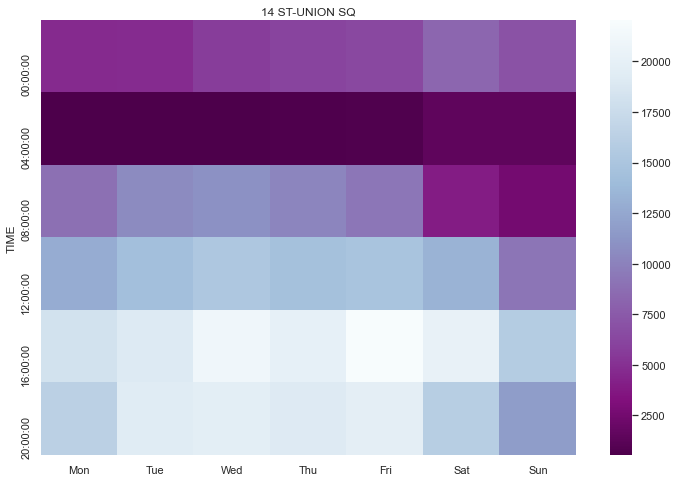

In [114]:
#14 ST-UNION SQ


station_of_interest = '14 ST-UNION SQ'

mta_penn = mta[mta['STATION'] == station_of_interest]
time_interval = '4H'

stations_day_time = mta_penn[['STATION', 'datetime','turn_traffic', 'day_of_week']]
stations_day_time_group = stations_day_time.groupby(['STATION','datetime'], as_index=False)
stations_day_time = stations_day_time_group[['turn_traffic']].sum()
rounded_day_time = stations_day_time.set_index('datetime').groupby(['STATION'])
rounded_day_time = rounded_day_time.resample(time_interval, convention='end').sum()

rounded_day_time = rounded_day_time.reset_index()
stations_day_time = rounded_day_time
stations_day_time['DAY'] = stations_day_time['datetime'].dt.dayofweek
stations_day_time['TIME'] = stations_day_time['datetime'].dt.time
stations_day_time
stations_day_time_group = stations_day_time.groupby(['STATION','DAY','TIME'])
stations_day_time_group = stations_day_time_group['turn_traffic'].mean().reset_index()

draw_station = stations_day_time_group

station_heatmap = draw_station.set_index(['DAY', 'TIME']).turn_traffic.unstack(0)
weekdays = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
station_heatmap.columns = [weekdays[c] for c in station_heatmap.columns]

fig, ax4 = plt.subplots(figsize=(12, 8))
ax4.set(title= '' + station_of_interest , xlabel='', ylabel='Time')
sns.heatmap(station_heatmap,ax=ax4, cmap='BuPu_r')
plt.show();

In [118]:
#profile = ProfileReport(mta, title="MTA Profiling Report")
